In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
print ("plt version:[%s]"%(matplotlib.__version__))
print ("gym version:[%s]"%(gym.__version__))

plt version:[3.4.3]
gym version:[0.20.0]


In [2]:
 def display_q_value(Q, title="Q Function",fig_size=8,text_fs=9,title_fs=15):
    """
    Display Q value
    """
    n_state, n_action = Q.shape
    nRow = 4
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])
    # Color
    high_color = np.array([1.0, 0.0, 0.0, 0.8])
    low_color  = np.array([1.0, 1.0, 1.0, 0.8])
    fig = plt.figure(figsize=(fig_size,fig_size))
    plt.title(title,fontsize=title_fs)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(Q[s])
            max_q = np.max(Q[s])
            for a in range(n_action):
                q_value = Q[s,a]
                ratio = (q_value - min_q)/(max_q - min_q + 1e-10) 
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i+0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i-0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
def visualize_matrix(M,strs='',fontsize=15,cmap='turbo',title='Title',title_fs=15,
                     fig_size=8,REMOVE_TICK_LABELS=True):
    """
    Visualize a matrix colors and strings 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]
    fig,ax = plt.subplots(figsize=(fig_size,fig_size))
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()

In [12]:
class SARSAAgent():
    def __init__(self,n_state,n_action,epsilon=1,alpha=0.1,gamma=0.99):
        self.n_state = n_state
        self.n_action= n_action
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma =gamma
        self.Q = np.zeros([n_state,n_action])
        
    def update_Q(self, state,action,reward,state_prime, action_prime,done):
        Q_old = self.Q[state,action]
        if done :
            td_target = reward
        else :
            td_target = self.gamma*self.Q[state_prime,action_prime]
        td_error = td_target - Q_old
        self.Q[state,action] = Q_old+self.alpha*td_error
        
        #choose E- greedy policy
    def update_epsilon(self, epsilon):
        self.epsilon = np.min([epsilon,1])

    def get_action(self,state):
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0,high=self.n_action)
        else:
            action = np.argmax(self.Q[state])
        return action
        

In [13]:
env = gym.make('FrozenLake-v1')
n_state = env.observation_space.n
n_action = env.action_space.n
agent = SARSAAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)

n_episiode = 10000

for e_idx in range(n_episiode):
    state = env.reset()
    action = agent.get_action(state)
    done = False
    while not done:
        state_prime,reward,done,_ =env.step(action)
        action_prime = agent.get_action(state_prime)
        agent.update_Q(state,action,reward,state_prime,action_prime,done)
        state = state_prime
        action = action_prime
    agent.update_epsilon(100/(e_idx+1))
print("sarsa done.")

sarsa done.


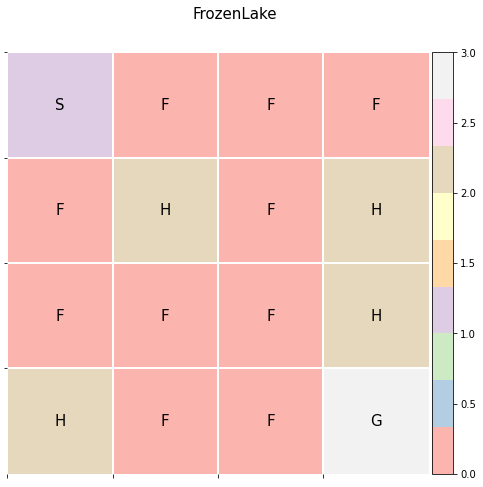

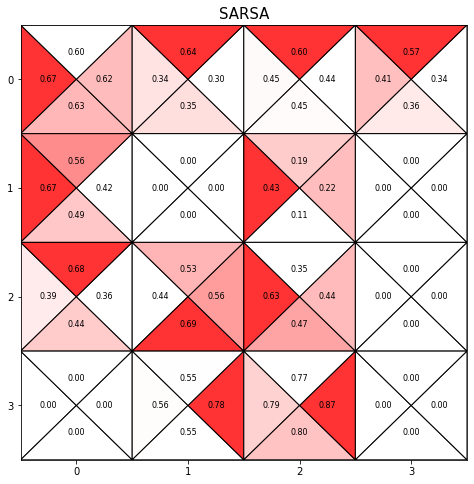

In [14]:
# Plot env
E = np.zeros(shape=(4,4))
strs = ['S','F','F','F',
        'F','H','F','H',
        'F','F','F','H',
        'H','F','F','G',]
E[0,0] = 1 # Start
E[1,1]=E[1,3]=E[2,3]=E[3,0]=2 # Hole
E[3,3] = 3 # Goal
visualize_matrix(E,strs=strs,cmap='Pastel1',title='FrozenLake',fig_size=7)

# Plot Q
display_q_value(agent.Q,title="SARSA",
                fig_size=8,text_fs=8,title_fs=15)

In [15]:
# Test
gamma = 0.99
env = gym.make('FrozenLake-v1')
obs = env.reset() # reset
ret = 0
state = 0
for tick in range(1000):
    print("\n tick:[{}]".format(tick))
    env.render(mode='human')
    action = agent.get_action(state) # select action
    next_obs,reward,done,info = env.step(action)
    obs = next_obs
    ret = reward + gamma*ret 
    state = next_obs
    if done: break
env.render(mode='human')
env.close()
print ("Return is [{:.3f}]".format(ret))


 tick:[0]

SFFF
FHFH
FFFH
HFFG

 tick:[1]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[2]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[3]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[4]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[5]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[6]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[7]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[8]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[9]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[10]
  (Up)
SFFF
FHFH
FFFH
HFFG

 tick:[11]
  (Down)
SFFF
FHFH
FFFH
HFFG

 tick:[12]
  (Left)
SFFF
FHFH
FFFH
HFFG

 tick:[13]
  (Right)
SFFF
FHFH
FFFH
HFFG

 tick:[14]
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
Return is [1.000]


In [36]:
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

In [37]:
env = CliffWalkingEnv()

In [38]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [39]:
env.nS

48

In [40]:
env.unwrapped.P[36][1]

[(1.0, 36, -100, False)]

In [41]:
for s in range(48):
    for a in range(4):
        if env.P[s][a][0][2] == -100:
            env.P[s][a][0] = (env.P[s][a][0][0], env.P[s][a][0][1], env.P[s][a][0][2], True)

In [42]:
env.unwrapped.P[36][1]

[(1.0, 36, -100, True)]

In [43]:
n_state = env.observation_space.n
n_action = env.action_space.n

In [53]:
from time import sleep
n_state = env.observation_space.n
n_action = env.action_space.n
agent = SARSAAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)

n_episiode = 1000

for e_idx in range(n_episiode):
    state = env.reset()
    action = agent.get_action(state)
    done = False
    while not done:
        state_prime,reward,done,_ =env.step(action)
        action_prime = agent.get_action(state_prime)
        agent.update_Q(state,action,reward,state_prime,action_prime,done)
        state = state_prime
        action = action_prime
    agent.update_epsilon(100/(e_idx+1))
print("sarsa done.")

sarsa done.


In [54]:
done = False
state = env.reset()
env.render()
while not done:
    action = agent.get_action(state)
    next_state,reward, done,_ = env.step(action)
    state = next_state
    env.render()
    sleep(1)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  x  o

In [102]:
class Q_learningAgent:
    def __init__(self,n_state, n_action=0.5,alpha=0.5,epsilon=1,gamma = 0.99):
        self.n_state = n_state
        self.n_action= n_action
        self.epsilon = epsilon
        self.alpha = alpha
        self.alpha_init = alpha
        self.epsilon_init = epsilon
        self.gamma =gamma
        
        self.Q = np.zeros([n_state,n_action])
    def update_Q(self,state,action,reward,state_prime,done):
        Q_old = self.Q[state][action]
        if done:
            td_target = reward
        else:
            td_target = reward +self.gamma*np.max(self.Q[state_prime])
        td_error = td_target - Q_old
        self.Q[state,action] = Q_old +td_error*self.alpha
    
    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,self.epsilon_init])
        
    def update_alpha(self,alpha):
        self.alpha = np.min([alpha,self.alpha_init])
    
    def get_action(self,state):
        if np.random.uniform()< self.epsilon:
            action = np.random.randint(0,high=self.n_action)
        else:
            action = np.argmax(self.Q[state])
        return action
            

In [103]:
from gym.envs.toy_text.cliffwalking import CliffWalkingEnv

In [104]:
env = CliffWalkingEnv()
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [105]:
env.unwrapped.P[36]

{0: [(1.0, 24, -1, False)],
 1: [(1.0, 36, -100, False)],
 2: [(1.0, 36, -1, False)],
 3: [(1.0, 36, -1, False)]}

In [110]:
n_state = env.nS
n_state = env.nA
action_space = ["up", "right", "down", "left"]
agent = Q_learningAgent(n_state,n_action,epsilon=1,alpha=0.1,gamma=0.99)

In [111]:
n_state = env.observation_space.n
n_action = env.action_space.n
agent = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)

# Loop
n_episode = 1000
for e_idx in range(n_episode):
    state = env.reset() # reset environment, select initial 
    action = agent.get_action(state)
    done = False
    while not done:
        state_prime, reward, done, info = env.step(action) # step 
        action_prime = agent.get_action(state_prime) # 
        
        Get next action
        agent.update_Q(state, action, reward, state_prime, done) # learns Q
        state = state_prime
        action = action_prime
    agent.update_epsilon(100/(e_idx+1)) # Decaying epsilon
print ("Q-learning done.")

Q-learning done.


In [113]:
is_terminal = False
state = env.reset()
env.render()
while not is_terminal:
    action = agent.get_action(state)
    print("Action taken:", action_space[action])
    next_state, reward, is_terminal, t_prob = env.step(action)
    print("Transition probability:", t_prob)
    print("Next state:", next_state)
    print("Reward recieved:", reward)
    print("Terminal state:", is_terminal)
    state = next_state
    env.render()
    sleep(1)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Action taken: up
Transition probability: {'prob': 1.0}
Next state: 24
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 25
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 26
Reward recieved: -1
Terminal state: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Action taken: right
Transition probability: {'prob': 1.0}
Next state: 27
Reward recieved: -1
T